In [15]:
%pip install pyspark
%pip install findspark
%pip install spark-nlp
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


24/05/12 05:23:18 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


In [1]:
# %%
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr , col , sum as sum_func , when ,mean as _mean, stddev as _stddev, col , collect_list
from pyspark.sql import functions as F
from pyspark.sql.types import *
from IPython.display import display
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import sparknlp

import numpy as np
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier , DecisionTreeClassifier , GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [2]:
# %%
import findspark
findspark.init()
findspark.find()

'/anaconda/envs/jupyter_env/lib/python3.8/site-packages/pyspark'

In [3]:
# %%
# Create a SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("MyApp") \
    .config("spark.executor.memory", "64g") \
    .config("spark.driver.memory", "64g") \
    .getOrCreate()

24/05/12 12:46:14 WARN Utils: Your hostname, bdsongscompute2 resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
24/05/12 12:46:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/12 12:46:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load scaled Features

In [4]:
#load scaled features
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

features_genre_df = spark.read.csv("120kData/" , header=True)

In [5]:

features_genre_df.na.drop()

features = [col_name for col_name in features_genre_df.columns if col_name != "genre"]

for feature in features:
    features_genre_df = features_genre_df.withColumn(feature , col(feature).cast("double"))



In [6]:
# Index the string column 'genre' to a numerical column 'indexed_genre'
stringIndexer = StringIndexer(inputCol="genre", outputCol="indexed_genre")
si_model = stringIndexer.fit(features_genre_df)
td = si_model.transform(features_genre_df)

assembler = VectorAssembler(inputCols=features, outputCol="features")
td = assembler.transform(td)

In [7]:

features_genre_df.unpersist
del features_genre_df

# Genres Mapping Dataframe

In [8]:
genresDf = td.select("indexed_genre"  , "genre").distinct()
genresDf.show()
td = td.select("indexed_genre" , "features")



td.printSchema()

+-------------+-------------------+
|indexed_genre|              genre|
+-------------+-------------------+
|          1.0|Minimal / Deep Tech|
|          0.0|        Trap / Wave|
|          5.0|         Psy-Trance|
|          4.0|        Drum & Bass|
|          2.0|        Electronica|
|          3.0|   Nu Disco / Disco|
+-------------+-------------------+

root
 |-- indexed_genre: double (nullable = false)
 |-- features: vector (nullable = true)



In [16]:
# compute accuracy on the test set
def print_results(model , test_data , genresDF):
    results = {}
    global_accuracy = 0
    global_precision = 0
    global_recall = 0
    global_f1 = 0
    result = model.transform(test_data).select("prediction", "indexed_genre")
    genres = result.select("indexed_genre").distinct().select(F.collect_list('indexed_genre')).first()[0]
    Total_count = result.count()
    for genre in genres:
        genreLabel = genresDF.filter(col("indexed_genre") == genre).select("genre").first()[0]
        TP = result.filter((col("prediction") == genre) & (col("indexed_genre") == genre)).count()
        FP = result.filter((col("prediction") == genre) & (col("indexed_genre") != genre)).count()
        FN = result.filter((col("prediction") != genre) & (col("indexed_genre") == genre)).count()
        count = result.filter((col("indexed_genre") == genre)).count()
        
        precision = ((TP))/(TP+FP)
        recall = ((TP))/(TP+FN)
        f1 = (2*(precision * recall))/(precision + recall)

        global_accuracy += (TP/Total_count)
        global_precision += (count * precision)/Total_count
        global_recall += (count * recall)/Total_count
        global_f1 += (count * f1)/Total_count

        results[genreLabel] = {
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }
    print("")
    print(f"Accuracy = {global_accuracy}")
    print(f"Precision = {global_precision}")
    print(f"Recall = {global_recall}")
    print(f"F1 = {global_f1}")


     # Plotting
    genres = list(results.keys())
    metrics = list(next(iter(results.values())).keys())
    n_genres = len(genres)
    n_metrics = len(metrics)

    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.2
    index = np.arange(n_genres)

    for i, metric in enumerate(metrics):
        values = [results[genre][metric] for genre in genres]
        ax.bar(index + (i - (n_metrics - 1) / 2) * bar_width, values, bar_width, label=metric)

    ax.set_xlabel('Genre')
    ax.set_ylabel('Value')
    ax.set_title('Metrics by Genre')
    ax.set_xticks(index)
    ax.set_xticklabels(genres)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

    
        
        


# Splitting Data To Train & Test 

In [10]:
# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = td.randomSplit([0.8, 0.2], seed=45)

td.unpersist
del td

# Random Forest Classifier

In [26]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(numTrees=200, maxDepth=20, labelCol="indexed_genre", seed=150,
                            leafCol="leafId")

In [27]:
# Train the model on the training data
model = rf.fit(train_data)

24/05/12 13:58:25 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
24/05/12 13:58:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
24/05/12 13:58:33 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
24/05/12 13:58:38 WARN DAGScheduler: Broadcasting large task binary with size 1520.0 KiB
24/05/12 13:58:40 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
24/05/12 13:58:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
24/05/12 13:58:49 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB
24/05/12 13:58:57 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
24/05/12 13:59:02 WARN DAGScheduler: Broadcasting large task binary with size 23.6 MiB
24/05/12 13:59:08 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/05/12 13:59:14 WARN DAGScheduler: Broadcasting large task binary with size 26.8 MiB
24/05/12 13:59:19 WARN DAGScheduler: Broadcas

24/05/12 14:10:42 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:12:09 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:13:44 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:14:59 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:16:11 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:17:49 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:19:07 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:20:41 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:22:05 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:23:26 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:24:46 WARN DAGScheduler: Broadcasting large task binary with size 479.2 MiB
24/05/12 14:26:09 WARN DAGSchedu


Accuracy = 0.8051748484093364
Precision = 0.8053169852639781
Recall = 0.8051748484093364
F1 = 0.8047976636246128


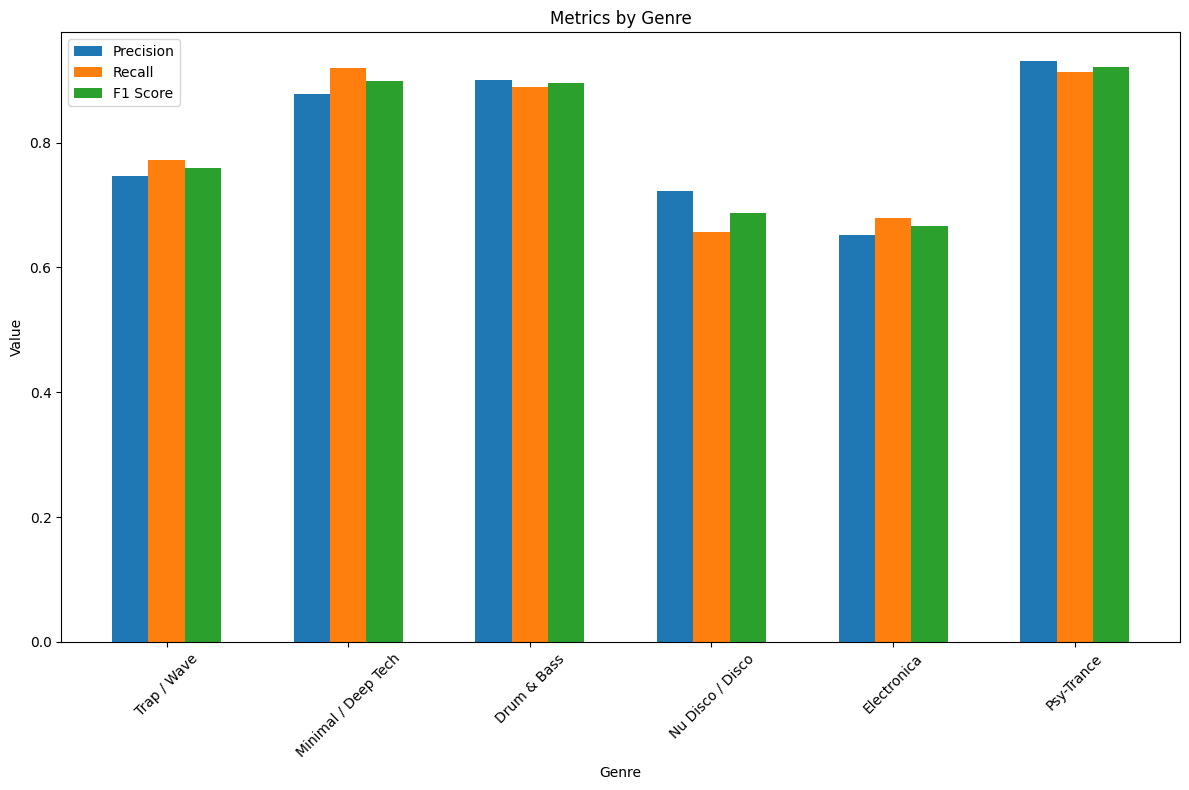

In [28]:
print_results(model , test_data , genresDf)

In [72]:
model.save("MLPModel")

In [73]:
import shutil

shutil.make_archive("MLPModel", 'zip', "MLPModel/")

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/bdsongscompute2/code/Users/14712019100076/MLPModel.zip'

# Decision Tree Classifier

In [11]:

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexed_genre", featuresCol="features" , maxDepth=30,  seed = 42 , maxBins=128 )

In [12]:
# Train model.  This also runs the indexers.
model = dt.fit(train_data)

24/05/12 12:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1174.6 KiB
24/05/12 12:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1573.8 KiB
24/05/12 12:47:02 WARN DAGScheduler: Broadcasting large task binary with size 2019.3 KiB
24/05/12 12:47:03 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
24/05/12 12:47:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/12 12:47:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:47:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
24/05/12 12:47:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/12 12:47:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/05/12 12:47:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/12 12:47:12 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/05/12 12:47:12 WARN DAGScheduler: Broadcas

24/05/12 12:53:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:15 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:18 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:19 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:23 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:26 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
24/05/12 12:53:28 WARN DAGScheduler: Broadcasting larg


Accuracy = 0.7165877564581775
Precision = 0.715807865983403
Recall = 0.7165877564581775
F1 = 0.7161866065005141


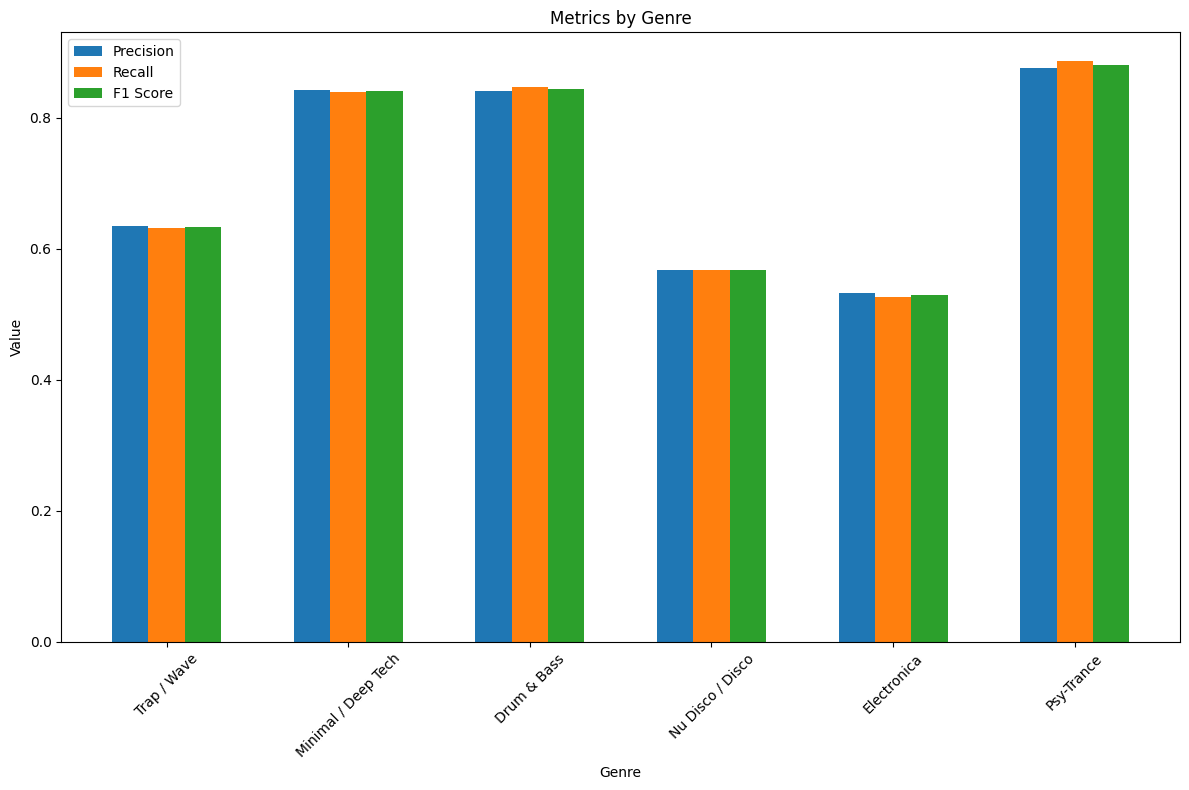

In [17]:
print_results(model , test_data , genresDf)

# Multilayer Perceptron Classifier

In [70]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# specify layers for the neural network:
layers = [13, 96 , 48 , 24, 20 , 6]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=1000, layers=layers, blockSize=256, seed=1234 , labelCol="indexed_genre")


In [71]:

# train the model
model = trainer.fit(train_data)


Accuracy = 0.7902649721737686
Precision = 0.7888510297192691
Recall = 0.7902649721737686
F1 = 0.7890257848079231


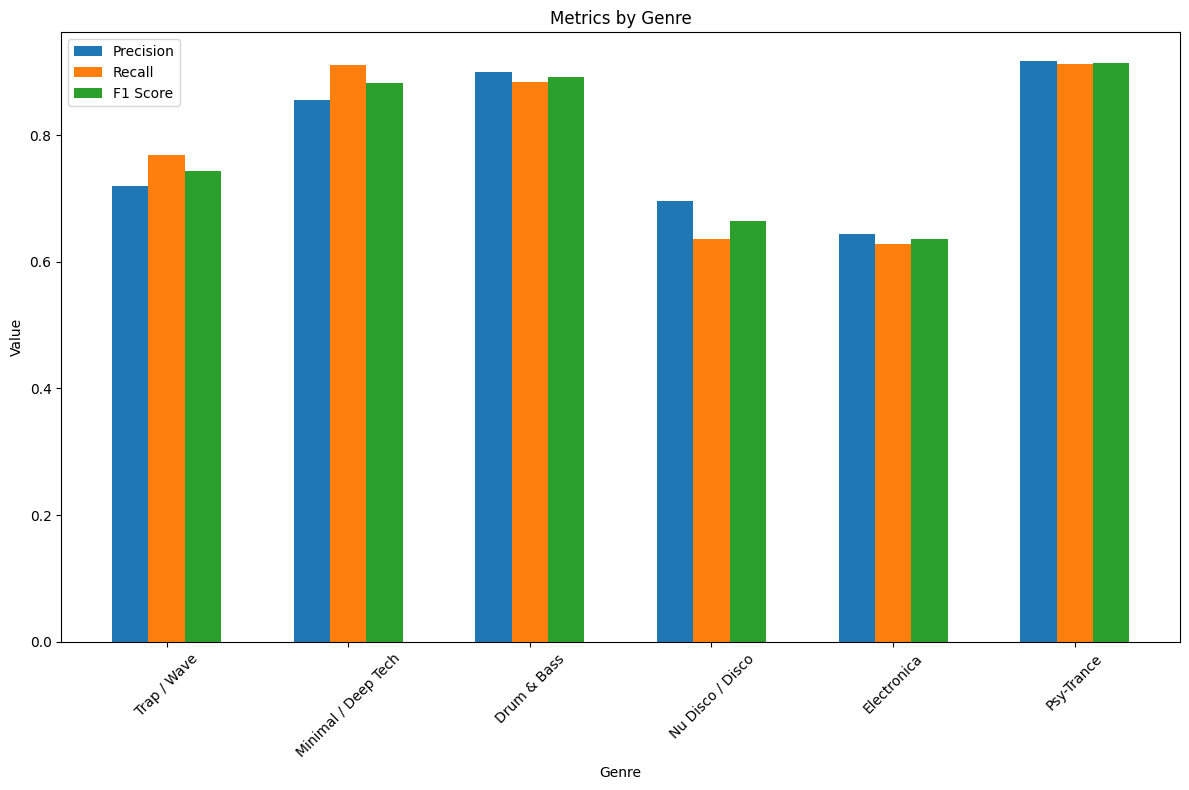

In [20]:
print_results(model , test_data , genresDf)

# Logistic Regression

In [64]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100000, regParam=0, elasticNetParam=0, labelCol="indexed_genre" , )

In [65]:
# Fit the model
lrModel = lr.fit(train_data)

In [66]:

trainingSummary = lrModel.summary

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.06190493970055632
label 1: 0.06646127854108176
label 2: 0.06280151191127469
label 3: 0.0819116441928034
label 4: 0.048998298411436665
label 5: 0.0402657939105425
True positive rate by label:
label 0: 0.6924118407286602
label 1: 0.8611180124223603
label 2: 0.4974025974025974
label 3: 0.5943960149439601
label 4: 0.7534970469381411
label 5: 0.7913267227312665
Precision by label:
label 0: 0.6934360554699538
label 1: 0.7215571978765484
label 2: 0.6142508018939973
label 3: 0.5913398996469058
label 4: 0.7544351073762838
label 5: 0.7951693258497824
Recall by label:
label 0: 0.6924118407286602
label 1: 0.8611180124223603
label 2: 0.4974025974025974
label 3: 0.5943960149439601
label 4: 0.7534970469381411
label 5: 0.7913267227312665
F-measure by label:
label 0: 0.6929235696249307
label 1: 0.785184346151668
label 2: 0.5496856205576819
label 3: 0.5928640188802285
label 4: 0.7539657853810264
label 5: 0.7932433707653109
Accuracy: 0.6980786351684299
FPR: 0.0604

In [62]:
from pyspark.ml.classification import OneVsRest
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr , labelCol="indexed_genre")

# train the multiclass model.
ovrModel = ovr.fit(train_data)


Accuracy = 0.6943683030152006
Precision = 0.6912636621441866
Recall = 0.6943683030152006
F1 = 0.6900294646681788


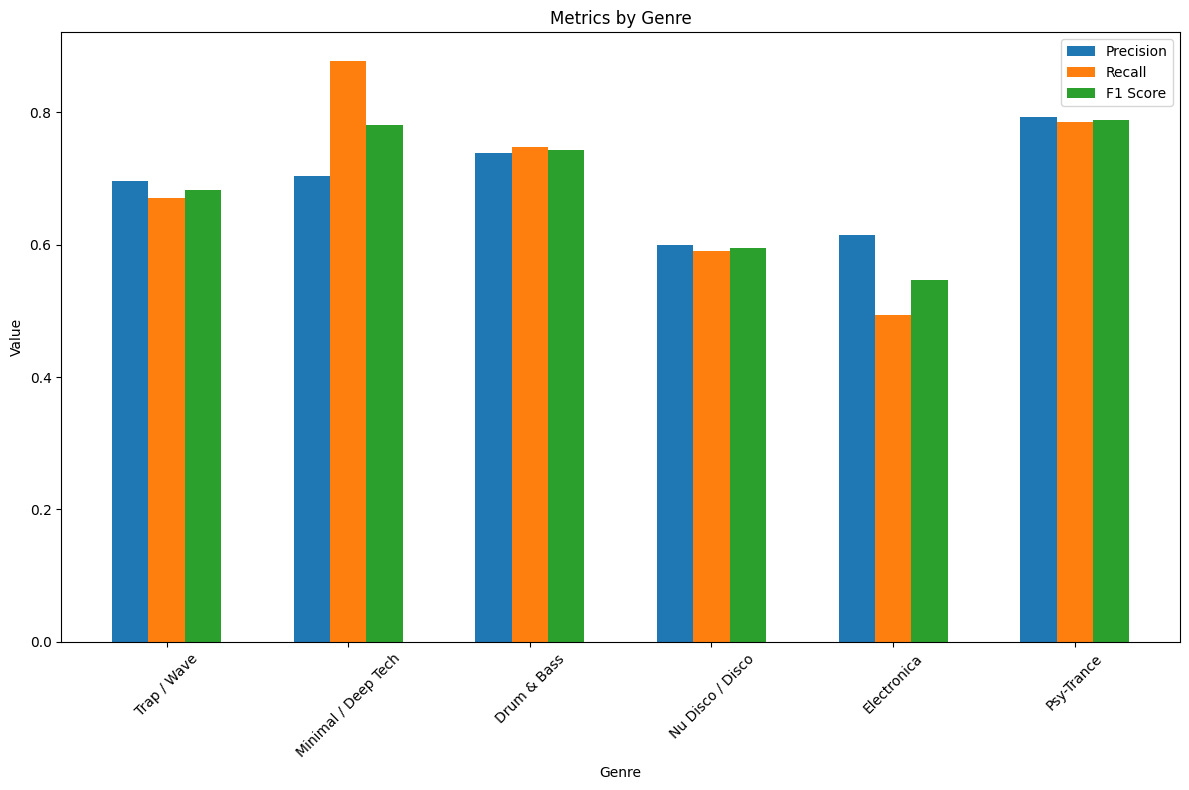

In [63]:
print_results(ovrModel , test_data , genresDf)


In [30]:
def print_sklearn_results(model, test_Data, test_labels , genresDF):
    score_matrix =[[0 for i in range(6)] for j in range(6)]
    
    results = {}

    global_accuracy = 0
    global_precision = 0
    global_recall =0
    global_f1=0

    for i in range(len(test_labels)):
        pred = model.predict([test_Data[i]])
        score_matrix[int(test_labels[i])][int(pred[0])] += 1
    Total_count = sum(sum(row) for row in score_matrix)
    #normalize the confusion matrix
    for index in range(6):
        count = sum(score_matrix[index])
        genreLabel = genresDF.filter(col("indexed_genre") == index).select("genre").first()[0]
        TP = score_matrix[index][index]

        predicted_positives = sum(row[index] for row in score_matrix)
        
        # Calculate FP and FN
        FP = predicted_positives - TP
        FN = count - TP

        
        
        precision = ((TP))/(TP+FP)
        recall = ((TP))/(TP+FN)
        f1 = (2*(precision * recall))/(precision + recall)

        global_accuracy += (TP)/Total_count
        global_precision += (count * precision)/Total_count
        global_recall += (count * recall)/Total_count
        global_f1 += (count * f1)/Total_count

        results[genreLabel] = {
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    print("")
    print(f"Accuracy = {global_accuracy}")
    print(f"Precision = {global_precision}")
    print(f"Recall = {global_recall}")
    print(f"F1 = {global_f1}")


    # Plotting
    genres = list(results.keys())
    metrics = list(next(iter(results.values())).keys())
    n_genres = len(genres)
    n_metrics = len(metrics)

    fig, ax = plt.subplots(figsize=(12, 8))

    bar_width = 0.2
    index = np.arange(n_genres)

    for i, metric in enumerate(metrics):
        values = [results[genre][metric] for genre in genres]
        ax.bar(index + (i - (n_metrics - 1) / 2) * bar_width, values, bar_width, label=metric)

    ax.set_xlabel('Genre')
    ax.set_ylabel('Value')
    ax.set_title('Metrics by Genre')
    ax.set_xticks(index)
    ax.set_xticklabels(genres)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
         

# SVM

In [47]:
from sklearn.svm import SVC
# train the model
model = SVC(kernel="rbf" , break_ties=True  )


In [48]:
trainLabels = [item for sublist in train_data.select("indexed_genre").toPandas().to_numpy() for item in sublist]
trainData = np.array([vector[0].toArray() for vector in train_data.drop("indexed_genre").collect()])
model.fit(trainData , trainLabels)

SVC(break_ties=True)


Accuracy = 0.7454107484010299
Precision = 0.7435330859024151
Recall = 0.7454107484010299
F1 = 0.7436704188188712


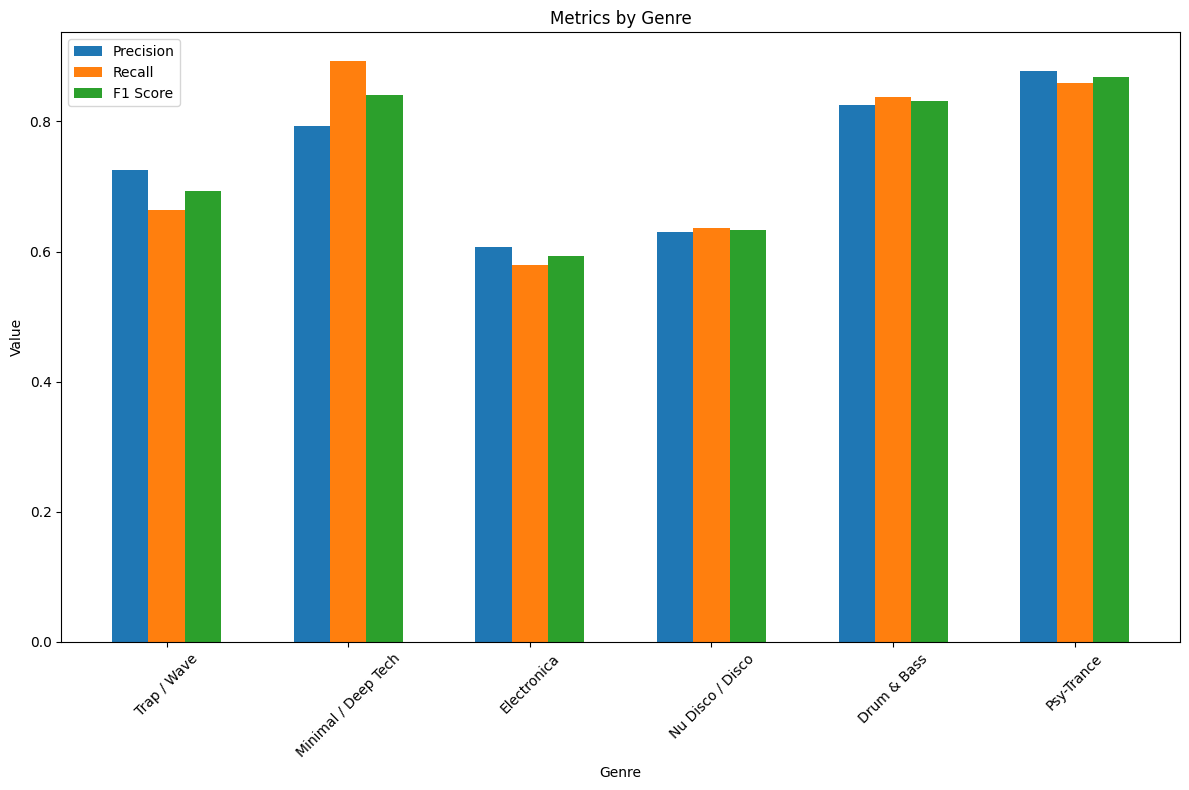

In [49]:
testLabels = [item for sublist in test_data.select("indexed_genre").toPandas().to_numpy() for item in sublist]
testData = np.array([vector[0].toArray() for vector in test_data.drop("indexed_genre").collect()])

print_sklearn_results(model , testData , testLabels , genresDf)

In [51]:
import pickle
# save the model


# Serialize the data and write it to a file
with open('SVMmodel.pickle', 'wb') as f:
    pickle.dump(model, f)